In [ ]:
!pip install pmdarima
!pip install numpy==1.26.4

In [2]:
import pandas as pd
from pandas import DataFrame, Series

import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

CONFIG = {
    'data_url': 'drive/MyDrive/sp500_prices.csv',
    'date_col': 'Date',
    'price_col': 'Price'
}

def getDataFrame() -> DataFrame:
    dataset = pd.read_csv(CONFIG['data_url'], parse_dates=[CONFIG['date_col']], index_col=CONFIG['date_col']).sort_index()
    return dataset


def getPrice(dataframe: DataFrame) -> Series:
    return dataframe[CONFIG['price_col']]


def calculateMAE(y_true, y_pred):
    """
    Calculate the Mean Absolute Error between true and predicted values.

    Args:
        y_true: Array of actual/true values
        y_pred: Array of predicted values

    Returns:
        float: Mean Absolute Error value

    Raises:
        ValueError: If arrays are not 1-dimensional or have different lengths
    """

    if y_true.ndim != 1 or y_pred.ndim != 1:
        raise ValueError("Both arrays must be 1-dimensional.")

    if len(y_true) != len(y_pred):
        raise ValueError(f"Arrays must have the same length (y_true: {len(y_true)}, y_pred: {len(y_pred)})")

    return np.mean(np.abs(y_true - y_pred))


def split_sequence(sequence, window_size, horizon):
    """
    Split a time series sequence into input-output pairs for training.

    Args:
        sequence: List or array of sequential data points
        window_size: Number of timesteps to use as input features
        horizon: Number of timesteps to predict as output

    Returns:
        input_sequences: Array of input sequences, each of length window_size
        output_sequences: Array of corresponding output sequences, each of length horizon
    """

    X, y = [], []

    for start_index in range(len(sequence)):
        end_index = start_index + window_size
        output_end_index = end_index + horizon

        if output_end_index > len(sequence):
            break

        input_sequence = sequence[start_index:end_index]
        output_sequence = sequence[end_index:output_end_index]

        X.append(input_sequence)
        y.append(output_sequence)

    return np.array(X), np.array(y)


def split_train_test(raw_sequence, horizon):
    """
    Split a time series sequence into training and test sets.

    Args:
        raw_sequence: Complete time series sequence
        horizon: Number of timesteps to reserve for testing

    Returns:
        tuple: (train_seq, test_seq, split_idx) where split_idx is the index where split occurs
    """

    split_idx = len(raw_sequence) - horizon
    train_seq = raw_sequence[:split_idx]
    test_seq = raw_sequence[split_idx:]
    return train_seq, test_seq, split_idx


def graph_comparison(title, dataset, mae, original, predictions, split_idx):
    """
    Create visualization comparing original vs predicted values with two plots: full view and zoomed view.

    Args:
        title: Title for the plots
        dataset: DataFrame containing the original data with date index
        mae: Mean Absolute Error value to display on plots
        original: Array of original/true values
        predictions: Array of predicted values
        split_idx: Index where training/test split occurs

    Returns:
        None: Displays two matplotlib plots
    """

    date_index = dataset.index

    plt.figure(figsize=(15, 5))

    plt.plot(date_index, original, label='Original Price')

    test_dates = date_index[split_idx:]
    plt.plot(test_dates, predictions, label='Predicted Price')

    plt.axvline(x=date_index[split_idx], color='r', linestyle='--', label='Train/Test Split')

    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.title(title)

    start_date = date_index[len(date_index) - 3000]
    end_date = date_index[-1]
    plt.xlim(start_date, end_date)

    # Format x-axis to show only years
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())

    plt.text(0.02, 0.95, f'MAE: {mae:.2f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='lightgray', alpha=0.9),
             verticalalignment='top', fontsize=10, color='black')

    plt.legend()
    plt.show()

    # === ZOOMED IN PLOT ===

    plt.figure(figsize=(15, 5))

    plt.plot(date_index, original, label='Original Price')
    plt.plot(test_dates, predictions, label='Predicted Price')

    plt.axvline(x=date_index[split_idx], color='r', linestyle='--', label='Train/Test Split')

    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.title(title)

    start_date = date_index[len(date_index) - 1000]
    end_date = date_index[-1]
    plt.xlim(start_date, end_date)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())

    plt.text(0.02, 0.95, f'MAE: {mae:.2f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='lightgray', alpha=0.9),
             verticalalignment='top', fontsize=10, color='black')

    plt.legend()
    plt.show()

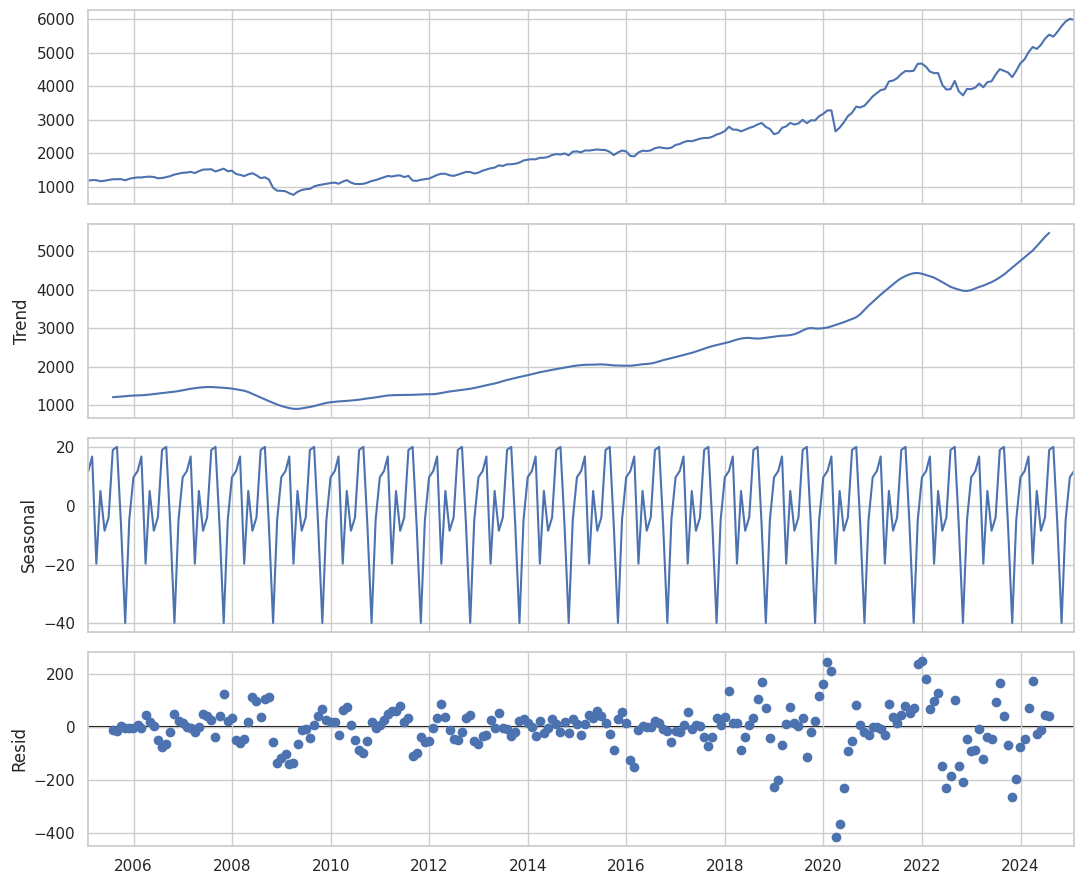

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

df = getDataFrame()

df_monthly = df.resample('M').mean()

decompose = seasonal_decompose(df_monthly)
decompose.plot()

plt.show()

In [14]:
ord_diff = np.diff(df_monthly['Price'], n=1) # non stationary data warrants 1st order difference
adf_res = adfuller(ord_diff)  # stationality test (p < 0.5 is good)

print(f'p-value: {adf_res[1]}')

# can't use built in split b/c date unit is months, not days
train = df_monthly[:-24]
test = df_monthly[-24:]

# build model
model = SARIMAX(train,
                order = (2, 1, 3),
                seasonal_order = (0, 2, 2, 12),
                enforce_stationarity = False,
                enforce_invertibility = True, trend='c')

# fit model
result = model.fit(maxiter = 500, method = 'nm')

start = len(train)
end = len(train) + len(test) - 1

predictions = result.predict(start, end)
predictions_filled = predictions.resample('D').ffill() # monthly seasonal prediction, have to fill in daily values

print(predictions_filled)

p-value: 1.5559713507427526e-24
2023-02-28    3945.267413
2023-03-01    3945.267413
2023-03-02    3945.267413
2023-03-03    3945.267413
2023-03-04    3945.267413
                 ...     
2025-01-27    4450.109304
2025-01-28    4450.109304
2025-01-29    4450.109304
2025-01-30    4450.109304
2025-01-31    4488.548819
Freq: D, Name: predicted_mean, Length: 704, dtype: float64
